In [2]:
%matplotlib inline
from pylab import *
import numpy as np
import random as rand

Blocking Probability:  0.0888194986556
Average arrival:  0.219399036366
Average served:  0.206104890424


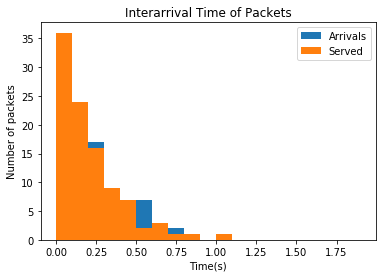

In [19]:
k = 5
mu = 5
la = 4
rho = la/mu
pb = np.power(rho,k) * ((1-rho)/(1-np.power(rho, k+1)))
print("Blocking Probability: ", pb)

a = []
s = []
for i in range(0,100):
    a.append(rand.expovariate(la))
    s.append(rand.expovariate(mu)) 
t = np.arange(0,2,0.1)
hist(a,t,label="Arrivals")
hist(s,t,label="Served")
title("Interarrival Time of Packets")
ylabel("Number of packets")
xlabel("Time(s)")
legend(loc="upper right")

print("Average arrival: ", average(a))
print("Average served: ", average(s))

show()